In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [2]:
df = pd.read_csv('Amazon_Beauty_Recommendation.csv')
df.head()

,UserId,ProductId,ProductType,Rating,Timestamp,URL
0,A3NHUQ33CFH3VM,B00LLPT4HI,Eyeliner & Kajal,5,1405814400,https://www.amazon.in/Maybelline-Colossal-Kaja...
1,A1TIRNQ7O4REOH,B00LLPT4HI,Eyeliner & Kajal,4,1405987200,https://www.amazon.in/Maybelline-Colossal-Kaja...
2,A2Y36BR4YSY9F7,B00LLPT4HI,Eyeliner & Kajal,5,1405728000,https://www.amazon.in/Maybelline-Colossal-Kaja...
3,A23H6FAOLEMAKC,B00LLPT4HI,Eyeliner & Kajal,5,1405814400,https://www.amazon.in/Maybelline-Colossal-Kaja...
4,A3CHYZGF3OO6WD,B00LLPT4HI,Eyeliner & Kajal,5,1405641600,https://www.amazon.in/Maybelline-Colossal-Kaja...


In [3]:
print(df[['UserId', 'ProductId', 'Timestamp']].head())

           UserId   ProductId   Timestamp
0  A3NHUQ33CFH3VM  B00LLPT4HI  1405814400
1  A1TIRNQ7O4REOH  B00LLPT4HI  1405987200
2  A2Y36BR4YSY9F7  B00LLPT4HI  1405728000
3  A23H6FAOLEMAKC  B00LLPT4HI  1405814400
4  A3CHYZGF3OO6WD  B00LLPT4HI  1405641600


In [4]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
print(df[['UserId', 'ProductId', 'Timestamp']].head())
print(df.shape)

           UserId   ProductId  Timestamp
0  A3NHUQ33CFH3VM  B00LLPT4HI 2014-07-20
1  A1TIRNQ7O4REOH  B00LLPT4HI 2014-07-22
2  A2Y36BR4YSY9F7  B00LLPT4HI 2014-07-19
3  A23H6FAOLEMAKC  B00LLPT4HI 2014-07-20
4  A3CHYZGF3OO6WD  B00LLPT4HI 2014-07-18
(1348246, 6)


In [5]:
user_counts = df['UserId'].value_counts()
filtered_users = user_counts[user_counts >= 5].index
df = df[df['UserId'].isin(filtered_users)]
print(f"Data after filtering: {df.shape}")

Data after filtering: (243601, 6)


In [6]:
item_counts = df['ProductId'].value_counts()
filtered_items = item_counts[item_counts >= 5].index
df = df[df['ProductId'].isin(filtered_items)]

print(f"Data after filtering: {df.shape}")

Data after filtering: (219119, 6)


In [7]:
user_encoder = LabelEncoder()
df['UserId'] = user_encoder.fit_transform(df['UserId'])+1
df['UserId'].max()

28035

In [8]:
item_encoder = LabelEncoder()
df['ProductId'] = item_encoder.fit_transform(df['ProductId']) + 1
df['ProductId'].max()

12704

In [9]:
num_items = df['ProductId'].max() + 1
print(f"Total number of items including padding index: {num_items}")

Total number of items including padding index: 12705


In [10]:
df = df.sort_values(['UserId', 'Timestamp']).reset_index(drop=True)
df.head()

,UserId,ProductId,ProductType,Rating,Timestamp,URL
0,1,12520,Shaving Foam & Gels,5,2014-07-14,https://www.amazon.in/gp/slredirect/picassoRed...
1,1,12421,Trimmers & Clippers,5,2014-07-14,https://www.amazon.in/Philips-BT3215-Cordless-...
2,1,11836,Kits & Accessories,3,2014-07-14,https://www.amazon.in/SUGAR-POP-Exclusive-Esse...
3,1,10802,Conditioner,1,2014-07-14,https://www.amazon.in/Garnier-Fructis-Strong-S...
4,1,10565,Conditioner,2,2014-07-14,https://www.amazon.in/LOreal-Paris-RESIST-Cond...


In [11]:
user_sequences = df.groupby('UserId')['ProductId'].apply(list).values
print(user_sequences[:5])
print(len(user_sequences))

[list([12520, 12421, 11836, 10802, 10565, 10186])
 list([3694, 9806, 5040, 4580, 11636, 55])
 list([6985, 4850, 4661, 9396, 6227, 492, 10974, 10137])
 list([10861, 9692, 9564, 9397, 10880, 10498, 3890])
 list([9662, 11043, 10892, 9089, 8810, 5610, 10951, 9564])]
28035


In [12]:
if (df['ProductId'] == 0).any():
    print("The encoder assigned 0 as a value for some ProductId entries.")
else:
    print("No ProductId entry has been assigned the value 0.")


No ProductId entry has been assigned the value 0.


In [13]:
def generate_sequences(sequence, window_size=10):
    if len(sequence) < window_size:
        sequence = [0] * (window_size - len(sequence)) + sequence
    return [sequence[i:i + window_size] for i in range(len(sequence) - window_size + 1)]

In [14]:
all_sequences = []
for seq in user_sequences:
    all_sequences.extend(generate_sequences(seq))
print(len(all_sequences))

67761


In [15]:
print(all_sequences[:20])

[[0, 0, 0, 0, 12520, 12421, 11836, 10802, 10565, 10186], [0, 0, 0, 0, 3694, 9806, 5040, 4580, 11636, 55], [0, 0, 6985, 4850, 4661, 9396, 6227, 492, 10974, 10137], [0, 0, 0, 10861, 9692, 9564, 9397, 10880, 10498, 3890], [0, 0, 9662, 11043, 10892, 9089, 8810, 5610, 10951, 9564], [0, 0, 0, 0, 0, 6643, 5649, 4783, 1095, 856], [10610, 4019, 4338, 9407, 8525, 8762, 6598, 3044, 9937, 5122], [4019, 4338, 9407, 8525, 8762, 6598, 3044, 9937, 5122, 9928], [4338, 9407, 8525, 8762, 6598, 3044, 9937, 5122, 9928, 8149], [0, 0, 0, 0, 0, 0, 11348, 11082, 11597, 11803], [0, 0, 0, 0, 11614, 10582, 10498, 10363, 10323, 7219], [0, 0, 0, 5906, 496, 4734, 2710, 4183, 3283, 3438], [0, 0, 0, 0, 652, 1347, 1046, 8589, 8108, 3266], [7817, 8269, 4328, 3350, 10986, 10303, 8594, 7245, 4337, 4336], [8269, 4328, 3350, 10986, 10303, 8594, 7245, 4337, 4336, 5958], [4328, 3350, 10986, 10303, 8594, 7245, 4337, 4336, 5958, 9353], [3350, 10986, 10303, 8594, 7245, 4337, 4336, 5958, 9353, 11083], [10986, 10303, 8594, 7245, 4

In [16]:
all_sequences = torch.tensor(all_sequences, dtype=torch.long)
inputs = all_sequences[:, :-1]
targets = all_sequences[:, -1]

In [17]:
print(inputs)


tensor([[    0,     0,     0,  ..., 11836, 10802, 10565],
        [    0,     0,     0,  ...,  5040,  4580, 11636],
        [    0,     0,  6985,  ...,  6227,   492, 10974],
        ...,
        [ 6122,  5562,  5362,  ...,  9933,  8364,  6481],
        [    0,     0,     0,  ..., 11713, 10830,  7269],
        [    0,     0,     0,  ...,  9392,  9265,  7728]])


In [18]:
print(inputs[:20])

tensor([[    0,     0,     0,     0, 12520, 12421, 11836, 10802, 10565],
        [    0,     0,     0,     0,  3694,  9806,  5040,  4580, 11636],
        [    0,     0,  6985,  4850,  4661,  9396,  6227,   492, 10974],
        [    0,     0,     0, 10861,  9692,  9564,  9397, 10880, 10498],
        [    0,     0,  9662, 11043, 10892,  9089,  8810,  5610, 10951],
        [    0,     0,     0,     0,     0,  6643,  5649,  4783,  1095],
        [10610,  4019,  4338,  9407,  8525,  8762,  6598,  3044,  9937],
        [ 4019,  4338,  9407,  8525,  8762,  6598,  3044,  9937,  5122],
        [ 4338,  9407,  8525,  8762,  6598,  3044,  9937,  5122,  9928],
        [    0,     0,     0,     0,     0,     0, 11348, 11082, 11597],
        [    0,     0,     0,     0, 11614, 10582, 10498, 10363, 10323],
        [    0,     0,     0,  5906,   496,  4734,  2710,  4183,  3283],
        [    0,     0,     0,     0,   652,  1347,  1046,  8589,  8108],
        [ 7817,  8269,  4328,  3350, 10986, 10303, 

In [19]:
print(targets)


tensor([10186,    55, 10137,  ...,  2814,  7351,  2347])


In [20]:
print(f'Inputs shape: {inputs.shape}, Targets shape: {targets.shape}')

Inputs shape: torch.Size([67761, 9]), Targets shape: torch.Size([67761])


In [21]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split


dataset = TensorDataset(inputs, targets)

total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(train_loader.dataset)}")
print(f"Validation size: {len(val_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")


Train size: 47432
Validation size: 10164
Test size: 10165


In [22]:
for batch_inputs, batch_targets in train_loader:
    print(f'Batch Inputs: {batch_inputs.shape}, Batch Targets: {batch_targets.shape}')
    break

Batch Inputs: torch.Size([32, 9]), Batch Targets: torch.Size([32])


In [23]:
import torch
import torch.nn as nn

class PointWiseFeedForward(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(PointWiseFeedForward, self).__init__()
        self.conv1 = nn.Conv1d(hidden_units, hidden_units, kernel_size=1)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(hidden_units, hidden_units, kernel_size=1)
        self.dropout2 = nn.Dropout(p=dropout_rate)

    def forward(self, inputs):
        outputs = self.dropout2(self.conv2(self.relu(self.dropout1(self.conv1(inputs.transpose(-1, -2))))))
        outputs = outputs.transpose(-1, -2)
        outputs += inputs
        return outputs

class SASRec(nn.Module):
    def __init__(self, user_num, item_num, args):
        super(SASRec, self).__init__()
        self.user_num = user_num
        self.item_num = item_num
        self.dev = args.device

        self.item_emb = nn.Embedding(self.item_num + 1, args.hidden_units, padding_idx=0)
        self.pos_emb = nn.Embedding(args.maxlen + 1, args.hidden_units, padding_idx=0)
        self.emb_dropout = nn.Dropout(p=args.dropout_rate)

        self.attention_layernorms = nn.ModuleList()
        self.attention_layers = nn.ModuleList()
        self.forward_layernorms = nn.ModuleList()
        self.forward_layers = nn.ModuleList()

        self.last_layernorm = nn.LayerNorm(args.hidden_units, eps=1e-8)

        for _ in range(args.num_blocks):
            self.attention_layernorms.append(nn.LayerNorm(args.hidden_units, eps=1e-8))
            self.attention_layers.append(
                nn.MultiheadAttention(args.hidden_units, args.num_heads, args.dropout_rate)
            )
            self.forward_layernorms.append(nn.LayerNorm(args.hidden_units, eps=1e-8))
            self.forward_layers.append(PointWiseFeedForward(args.hidden_units, args.dropout_rate))

    def forward(self, inputs, targets):
        embeddings = self.item_emb(inputs.to(self.dev))
        embeddings *= self.item_emb.embedding_dim ** 0.5
        seqs = self.emb_dropout(embeddings)

        for i in range(len(self.attention_layers)):
            Q = self.attention_layernorms[i](seqs)
            seqs, _ = self.attention_layers[i](Q, seqs, seqs)
            seqs = Q + seqs
            seqs = self.forward_layernorms[i](seqs)
            seqs = self.forward_layers[i](seqs)

        logits = seqs[:, -1, :]  
        logits = logits.matmul(self.item_emb.weight.t())

        return logits



In [24]:
args = type('Args', (object,), {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'hidden_units': 128,
    'num_blocks': 2,
    'num_heads': 2,
    'maxlen': 9,
    'dropout_rate': 0.2,
})()
user_num = len(df["UserId"].unique())
item_num = len(df["ProductId"].unique())
model = SASRec(user_num, item_num, args)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)


SASRec(
  (item_emb): Embedding(12705, 128, padding_idx=0)
  (pos_emb): Embedding(10, 128, padding_idx=0)
  (emb_dropout): Dropout(p=0.2, inplace=False)
  (attention_layernorms): ModuleList(
    (0-1): 2 x LayerNorm((128,), eps=1e-08, elementwise_affine=True)
  )
  (attention_layers): ModuleList(
    (0-1): 2 x MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
  )
  (forward_layernorms): ModuleList(
    (0-1): 2 x LayerNorm((128,), eps=1e-08, elementwise_affine=True)
  )
  (forward_layers): ModuleList(
    (0-1): 2 x PointWiseFeedForward(
      (conv1): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (dropout1): Dropout(p=0.2, inplace=False)
      (relu): ReLU()
      (conv2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (dropout2): Dropout(p=0.2, inplace=False)
    )
  )
  (last_layernorm): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
)


In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm
import numpy as np

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("Starting Training...")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as progress_bar:
        for batch_inputs, batch_targets in progress_bar:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

            optimizer.zero_grad()
            outputs = model(batch_inputs, batch_targets)  

            loss = criterion(outputs, batch_targets)  
            loss.backward()  
            optimizer.step()  

            total_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            correct_predictions += (predicted == batch_targets).sum().item()
            total_predictions += batch_targets.size(0)

            progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_predictions / total_predictions
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    with torch.no_grad():
        for batch_inputs, batch_targets in val_loader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

            outputs = model(batch_inputs, batch_targets)

            loss = criterion(outputs, batch_targets)
            val_loss += loss.item()

            _, val_predicted = torch.max(outputs, dim=1)
            val_correct_predictions += (val_predicted == batch_targets).sum().item()
            val_total_predictions += batch_targets.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct_predictions / val_total_predictions
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

np.save("train_losses.npy", train_losses)
np.save("val_losses.npy", val_losses)
np.save("train_accuracies.npy", train_accuracies)
np.save("val_accuracies.npy", val_accuracies)

final_model_path = "sasrec_model_final.pth"
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved as '{final_model_path}'.")

print("Training Completed. Metrics and model saved for future use.")


Starting Training...


Epoch [1/100]: 100%|██████████| 1483/1483 [00:10<00:00, 136.69batch/s, Batch Loss=9.32]


Epoch [1/100], Training Loss: 12.8146, Training Accuracy: 0.0002
Epoch [1/100], Validation Loss: 9.4142, Validation Accuracy: 0.0002


Epoch [2/100]: 100%|██████████| 1483/1483 [00:09<00:00, 148.56batch/s, Batch Loss=8.72]


Epoch [2/100], Training Loss: 9.2619, Training Accuracy: 0.0005
Epoch [2/100], Validation Loss: 9.2524, Validation Accuracy: 0.0013


Epoch [3/100]: 100%|██████████| 1483/1483 [00:10<00:00, 147.57batch/s, Batch Loss=8.89]


Epoch [3/100], Training Loss: 9.0028, Training Accuracy: 0.0013
Epoch [3/100], Validation Loss: 9.0522, Validation Accuracy: 0.0013


Epoch [4/100]: 100%|██████████| 1483/1483 [00:10<00:00, 147.00batch/s, Batch Loss=8.25]


Epoch [4/100], Training Loss: 8.8147, Training Accuracy: 0.0017
Epoch [4/100], Validation Loss: 8.9697, Validation Accuracy: 0.0024


Epoch [5/100]: 100%|██████████| 1483/1483 [00:10<00:00, 148.24batch/s, Batch Loss=8.9] 


Epoch [5/100], Training Loss: 8.7721, Training Accuracy: 0.0021
Epoch [5/100], Validation Loss: 8.9752, Validation Accuracy: 0.0026


Epoch [6/100]: 100%|██████████| 1483/1483 [00:09<00:00, 149.98batch/s, Batch Loss=8.7] 


Epoch [6/100], Training Loss: 8.7202, Training Accuracy: 0.0019
Epoch [6/100], Validation Loss: 8.9794, Validation Accuracy: 0.0018


Epoch [7/100]: 100%|██████████| 1483/1483 [00:09<00:00, 150.27batch/s, Batch Loss=8.69]


Epoch [7/100], Training Loss: 8.6969, Training Accuracy: 0.0018
Epoch [7/100], Validation Loss: 8.9759, Validation Accuracy: 0.0014


Epoch [8/100]: 100%|██████████| 1483/1483 [00:10<00:00, 148.00batch/s, Batch Loss=9.36]


Epoch [8/100], Training Loss: 8.6892, Training Accuracy: 0.0021
Epoch [8/100], Validation Loss: 8.9826, Validation Accuracy: 0.0026


Epoch [9/100]: 100%|██████████| 1483/1483 [00:09<00:00, 149.09batch/s, Batch Loss=8.52]


Epoch [9/100], Training Loss: 8.6804, Training Accuracy: 0.0023
Epoch [9/100], Validation Loss: 8.9823, Validation Accuracy: 0.0012


Epoch [10/100]: 100%|██████████| 1483/1483 [00:09<00:00, 149.27batch/s, Batch Loss=9.1] 


Epoch [10/100], Training Loss: 8.6786, Training Accuracy: 0.0017
Epoch [10/100], Validation Loss: 9.0034, Validation Accuracy: 0.0010


Epoch [11/100]: 100%|██████████| 1483/1483 [00:09<00:00, 149.64batch/s, Batch Loss=8.09]


Epoch [11/100], Training Loss: 8.6738, Training Accuracy: 0.0022
Epoch [11/100], Validation Loss: 9.0288, Validation Accuracy: 0.0023


Epoch [12/100]: 100%|██████████| 1483/1483 [00:09<00:00, 149.89batch/s, Batch Loss=8.84]


Epoch [12/100], Training Loss: 8.6698, Training Accuracy: 0.0020
Epoch [12/100], Validation Loss: 9.0130, Validation Accuracy: 0.0014


Epoch [13/100]: 100%|██████████| 1483/1483 [00:09<00:00, 150.62batch/s, Batch Loss=8.3] 


Epoch [13/100], Training Loss: 8.6679, Training Accuracy: 0.0020
Epoch [13/100], Validation Loss: 9.0047, Validation Accuracy: 0.0017


Epoch [14/100]: 100%|██████████| 1483/1483 [00:09<00:00, 150.46batch/s, Batch Loss=9.02]


Epoch [14/100], Training Loss: 8.6525, Training Accuracy: 0.0019
Epoch [14/100], Validation Loss: 8.9514, Validation Accuracy: 0.0018


Epoch [15/100]: 100%|██████████| 1483/1483 [00:09<00:00, 150.55batch/s, Batch Loss=9.39]


Epoch [15/100], Training Loss: 8.6214, Training Accuracy: 0.0024
Epoch [15/100], Validation Loss: 8.9211, Validation Accuracy: 0.0024


Epoch [16/100]: 100%|██████████| 1483/1483 [00:09<00:00, 149.92batch/s, Batch Loss=8.14]


Epoch [16/100], Training Loss: 8.5868, Training Accuracy: 0.0024
Epoch [16/100], Validation Loss: 8.8871, Validation Accuracy: 0.0026


Epoch [17/100]: 100%|██████████| 1483/1483 [00:10<00:00, 146.94batch/s, Batch Loss=8.69]


Epoch [17/100], Training Loss: 8.5674, Training Accuracy: 0.0028
Epoch [17/100], Validation Loss: 8.8721, Validation Accuracy: 0.0024


Epoch [18/100]: 100%|██████████| 1483/1483 [00:10<00:00, 148.00batch/s, Batch Loss=8.64]


Epoch [18/100], Training Loss: 8.5530, Training Accuracy: 0.0024
Epoch [18/100], Validation Loss: 8.8754, Validation Accuracy: 0.0022


Epoch [19/100]: 100%|██████████| 1483/1483 [00:09<00:00, 150.08batch/s, Batch Loss=8.78]


Epoch [19/100], Training Loss: 8.5377, Training Accuracy: 0.0027
Epoch [19/100], Validation Loss: 8.8556, Validation Accuracy: 0.0036


Epoch [20/100]: 100%|██████████| 1483/1483 [00:09<00:00, 150.53batch/s, Batch Loss=7.67]


Epoch [20/100], Training Loss: 8.5164, Training Accuracy: 0.0029
Epoch [20/100], Validation Loss: 8.8614, Validation Accuracy: 0.0022


Epoch [21/100]: 100%|██████████| 1483/1483 [00:10<00:00, 147.39batch/s, Batch Loss=8.7] 


Epoch [21/100], Training Loss: 8.4948, Training Accuracy: 0.0031
Epoch [21/100], Validation Loss: 8.8018, Validation Accuracy: 0.0033


Epoch [22/100]: 100%|██████████| 1483/1483 [00:09<00:00, 150.26batch/s, Batch Loss=7.4] 


Epoch [22/100], Training Loss: 8.4706, Training Accuracy: 0.0027
Epoch [22/100], Validation Loss: 8.8073, Validation Accuracy: 0.0023


Epoch [23/100]: 100%|██████████| 1483/1483 [00:10<00:00, 144.77batch/s, Batch Loss=9.03]


Epoch [23/100], Training Loss: 8.4434, Training Accuracy: 0.0031
Epoch [23/100], Validation Loss: 8.7984, Validation Accuracy: 0.0024


Epoch [24/100]: 100%|██████████| 1483/1483 [00:10<00:00, 142.99batch/s, Batch Loss=8.21]


Epoch [24/100], Training Loss: 8.4203, Training Accuracy: 0.0031
Epoch [24/100], Validation Loss: 8.7676, Validation Accuracy: 0.0028


Epoch [25/100]: 100%|██████████| 1483/1483 [00:10<00:00, 144.21batch/s, Batch Loss=8.02]


Epoch [25/100], Training Loss: 8.3958, Training Accuracy: 0.0034
Epoch [25/100], Validation Loss: 8.7617, Validation Accuracy: 0.0024


Epoch [26/100]: 100%|██████████| 1483/1483 [00:10<00:00, 147.91batch/s, Batch Loss=7.6] 


Epoch [26/100], Training Loss: 8.3785, Training Accuracy: 0.0030
Epoch [26/100], Validation Loss: 8.7405, Validation Accuracy: 0.0023


Epoch [27/100]: 100%|██████████| 1483/1483 [00:09<00:00, 148.76batch/s, Batch Loss=7.67]


Epoch [27/100], Training Loss: 8.3585, Training Accuracy: 0.0038
Epoch [27/100], Validation Loss: 8.7631, Validation Accuracy: 0.0026


Epoch [28/100]: 100%|██████████| 1483/1483 [00:10<00:00, 145.78batch/s, Batch Loss=8.59]


Epoch [28/100], Training Loss: 8.3440, Training Accuracy: 0.0038
Epoch [28/100], Validation Loss: 8.7155, Validation Accuracy: 0.0026


Epoch [29/100]: 100%|██████████| 1483/1483 [00:10<00:00, 144.73batch/s, Batch Loss=8.41]


Epoch [29/100], Training Loss: 8.3329, Training Accuracy: 0.0034
Epoch [29/100], Validation Loss: 8.7156, Validation Accuracy: 0.0034


Epoch [30/100]: 100%|██████████| 1483/1483 [00:10<00:00, 144.56batch/s, Batch Loss=8.34]


Epoch [30/100], Training Loss: 8.3227, Training Accuracy: 0.0033
Epoch [30/100], Validation Loss: 8.6767, Validation Accuracy: 0.0030


Epoch [31/100]: 100%|██████████| 1483/1483 [00:09<00:00, 149.04batch/s, Batch Loss=6.96]


Epoch [31/100], Training Loss: 8.3100, Training Accuracy: 0.0035
Epoch [31/100], Validation Loss: 8.6740, Validation Accuracy: 0.0024


Epoch [32/100]: 100%|██████████| 1483/1483 [00:10<00:00, 146.13batch/s, Batch Loss=7.79]


Epoch [32/100], Training Loss: 8.3026, Training Accuracy: 0.0039
Epoch [32/100], Validation Loss: 8.7355, Validation Accuracy: 0.0030


Epoch [33/100]: 100%|██████████| 1483/1483 [00:10<00:00, 146.41batch/s, Batch Loss=8.66]


Epoch [33/100], Training Loss: 8.2978, Training Accuracy: 0.0038
Epoch [33/100], Validation Loss: 8.7371, Validation Accuracy: 0.0033


Epoch [34/100]: 100%|██████████| 1483/1483 [00:10<00:00, 147.56batch/s, Batch Loss=8.32]


Epoch [34/100], Training Loss: 8.3000, Training Accuracy: 0.0032
Epoch [34/100], Validation Loss: 8.6503, Validation Accuracy: 0.0033


Epoch [35/100]: 100%|██████████| 1483/1483 [00:10<00:00, 147.82batch/s, Batch Loss=7.93]


Epoch [35/100], Training Loss: 8.2825, Training Accuracy: 0.0036
Epoch [35/100], Validation Loss: 8.6842, Validation Accuracy: 0.0025


Epoch [36/100]: 100%|██████████| 1483/1483 [00:09<00:00, 149.43batch/s, Batch Loss=9.06]


Epoch [36/100], Training Loss: 8.2734, Training Accuracy: 0.0034
Epoch [36/100], Validation Loss: 8.6720, Validation Accuracy: 0.0025


Epoch [37/100]: 100%|██████████| 1483/1483 [00:10<00:00, 147.06batch/s, Batch Loss=8.74]


Epoch [37/100], Training Loss: 8.2729, Training Accuracy: 0.0034
Epoch [37/100], Validation Loss: 8.6756, Validation Accuracy: 0.0032


Epoch [38/100]: 100%|██████████| 1483/1483 [00:10<00:00, 146.98batch/s, Batch Loss=8.41]


Epoch [38/100], Training Loss: 8.2713, Training Accuracy: 0.0039
Epoch [38/100], Validation Loss: 8.6979, Validation Accuracy: 0.0030


Epoch [39/100]: 100%|██████████| 1483/1483 [00:10<00:00, 147.81batch/s, Batch Loss=7.9] 


Epoch [39/100], Training Loss: 8.2675, Training Accuracy: 0.0038
Epoch [39/100], Validation Loss: 8.7072, Validation Accuracy: 0.0037


Epoch [40/100]:  70%|██████▉   | 1037/1483 [00:07<00:03, 147.06batch/s, Batch Loss=8.37]

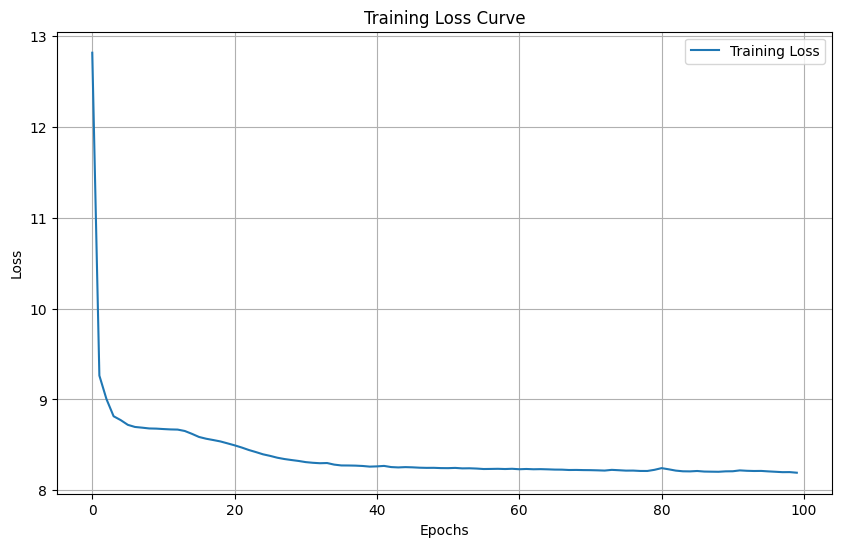

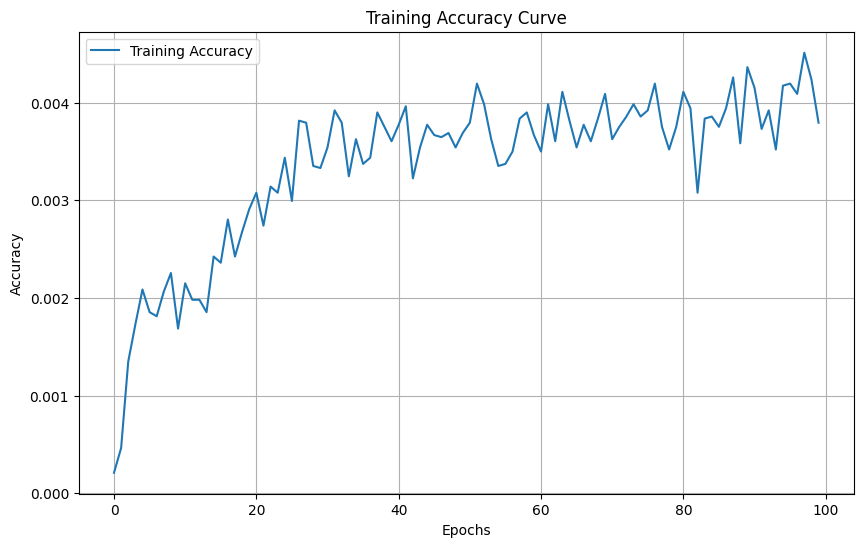

In [1]:
import numpy as np
import matplotlib.pyplot as plt

train_losses = np.load("train_losses.npy")
train_accuracies = np.load("train_accuracies.npy")

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig("loss_curve.png")  
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label="Training Accuracy")
plt.title("Training Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.savefig("accuracy_curve.png")  
plt.show()


In [27]:
model.load_state_dict(torch.load("sasrec_model_final.pth"))
model.eval()
print("Model loaded successfully.")

import numpy as np
from tqdm import tqdm

def evaluate_hit_ndcg_multi_k(model, test_loader, ks=[5, 10, 20]):
    model.eval()
    total_hr = {k: 0 for k in ks}
    total_ndcg = {k: 0 for k in ks}
    total_samples = 0

    with torch.no_grad():
        for batch_inputs, batch_targets in tqdm(test_loader, desc="Evaluating HR & NDCG for multiple k"):
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)

            # Pass targets=None during evaluation
            outputs = model(batch_inputs, targets=None)
            _, top_k_indices = torch.topk(outputs, k=max(ks), dim=1)

            for i in range(batch_targets.size(0)):
                target = batch_targets[i].item()
                predictions = top_k_indices[i].cpu().numpy()

                for k in ks:
                    top_k_preds = predictions[:k]

                    if target in top_k_preds:
                        total_hr[k] += 1

                    if target in top_k_preds:
                        rank = np.where(top_k_preds == target)[0][0] + 1
                        total_ndcg[k] += 1 / np.log2(rank + 1)

            total_samples += batch_targets.size(0)

    hr = {k: total_hr[k] / total_samples for k in ks}
    ndcg = {k: total_ndcg[k] / total_samples for k in ks}

    for k in ks:
        print(f"Hit Ratio@{k}: {hr[k]:.4f}, NDCG@{k}: {ndcg[k]:.4f}")

    return hr, ndcg


ks = [5, 10, 20]
hr, ndcg = evaluate_hit_ndcg_multi_k(model, test_loader, ks=ks)


Model loaded successfully.


Evaluating HR & NDCG for multiple k: 100%|██████████| 318/318 [00:01<00:00, 232.38it/s]

Hit Ratio@5: 0.0210, NDCG@5: 0.0125
Hit Ratio@10: 0.0320, NDCG@10: 0.0161
Hit Ratio@20: 0.0513, NDCG@20: 0.0209
